## Metrics

汇总常见2分类的指标，例如: AUC，ROC曲线，ACC, 敏感性， 特异性，精确度，召回率，PPV, NPV, F1

具体的介绍，可以参考一下：https://blog.csdn.net/sunflower_sara/article/details/81214897

In [38]:
import os
import pandas as pd
from datetime import datetime
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
group_info = pd.read_csv(get_param_in_cwd('label_file'))[['ID', 'group']]
group_info['ID'] = group_info['ID'].map(lambda x: x.replace('.png', '.gz'))
group_info

,ID,group
0,DONG HUIP00343158.nii.gz,train
1,YAO YU MING_P00096109.nii.gz,train
2,DENG YUE YINGP00332485.nii.gz,train
3,JIANG XIU JUAN_P00104388.nii.gz,train
4,DAI_XIAO_HUI_P00307303.nii.gz,train
...,...,...
284,ZHAO_YUN_P00310065.nii.gz,test
285,ZHAO_ZHANG_ZHI_P00206369.nii.gz,test
286,ZHENG_XI_DE_P00266862.nii.gz,test
287,ZHOU_RONG_P00306340.nii.gz,test


CT 29 8 train (146, 7)
CT 29 8 val (63, 7)
CT 29 8 test (80, 7)


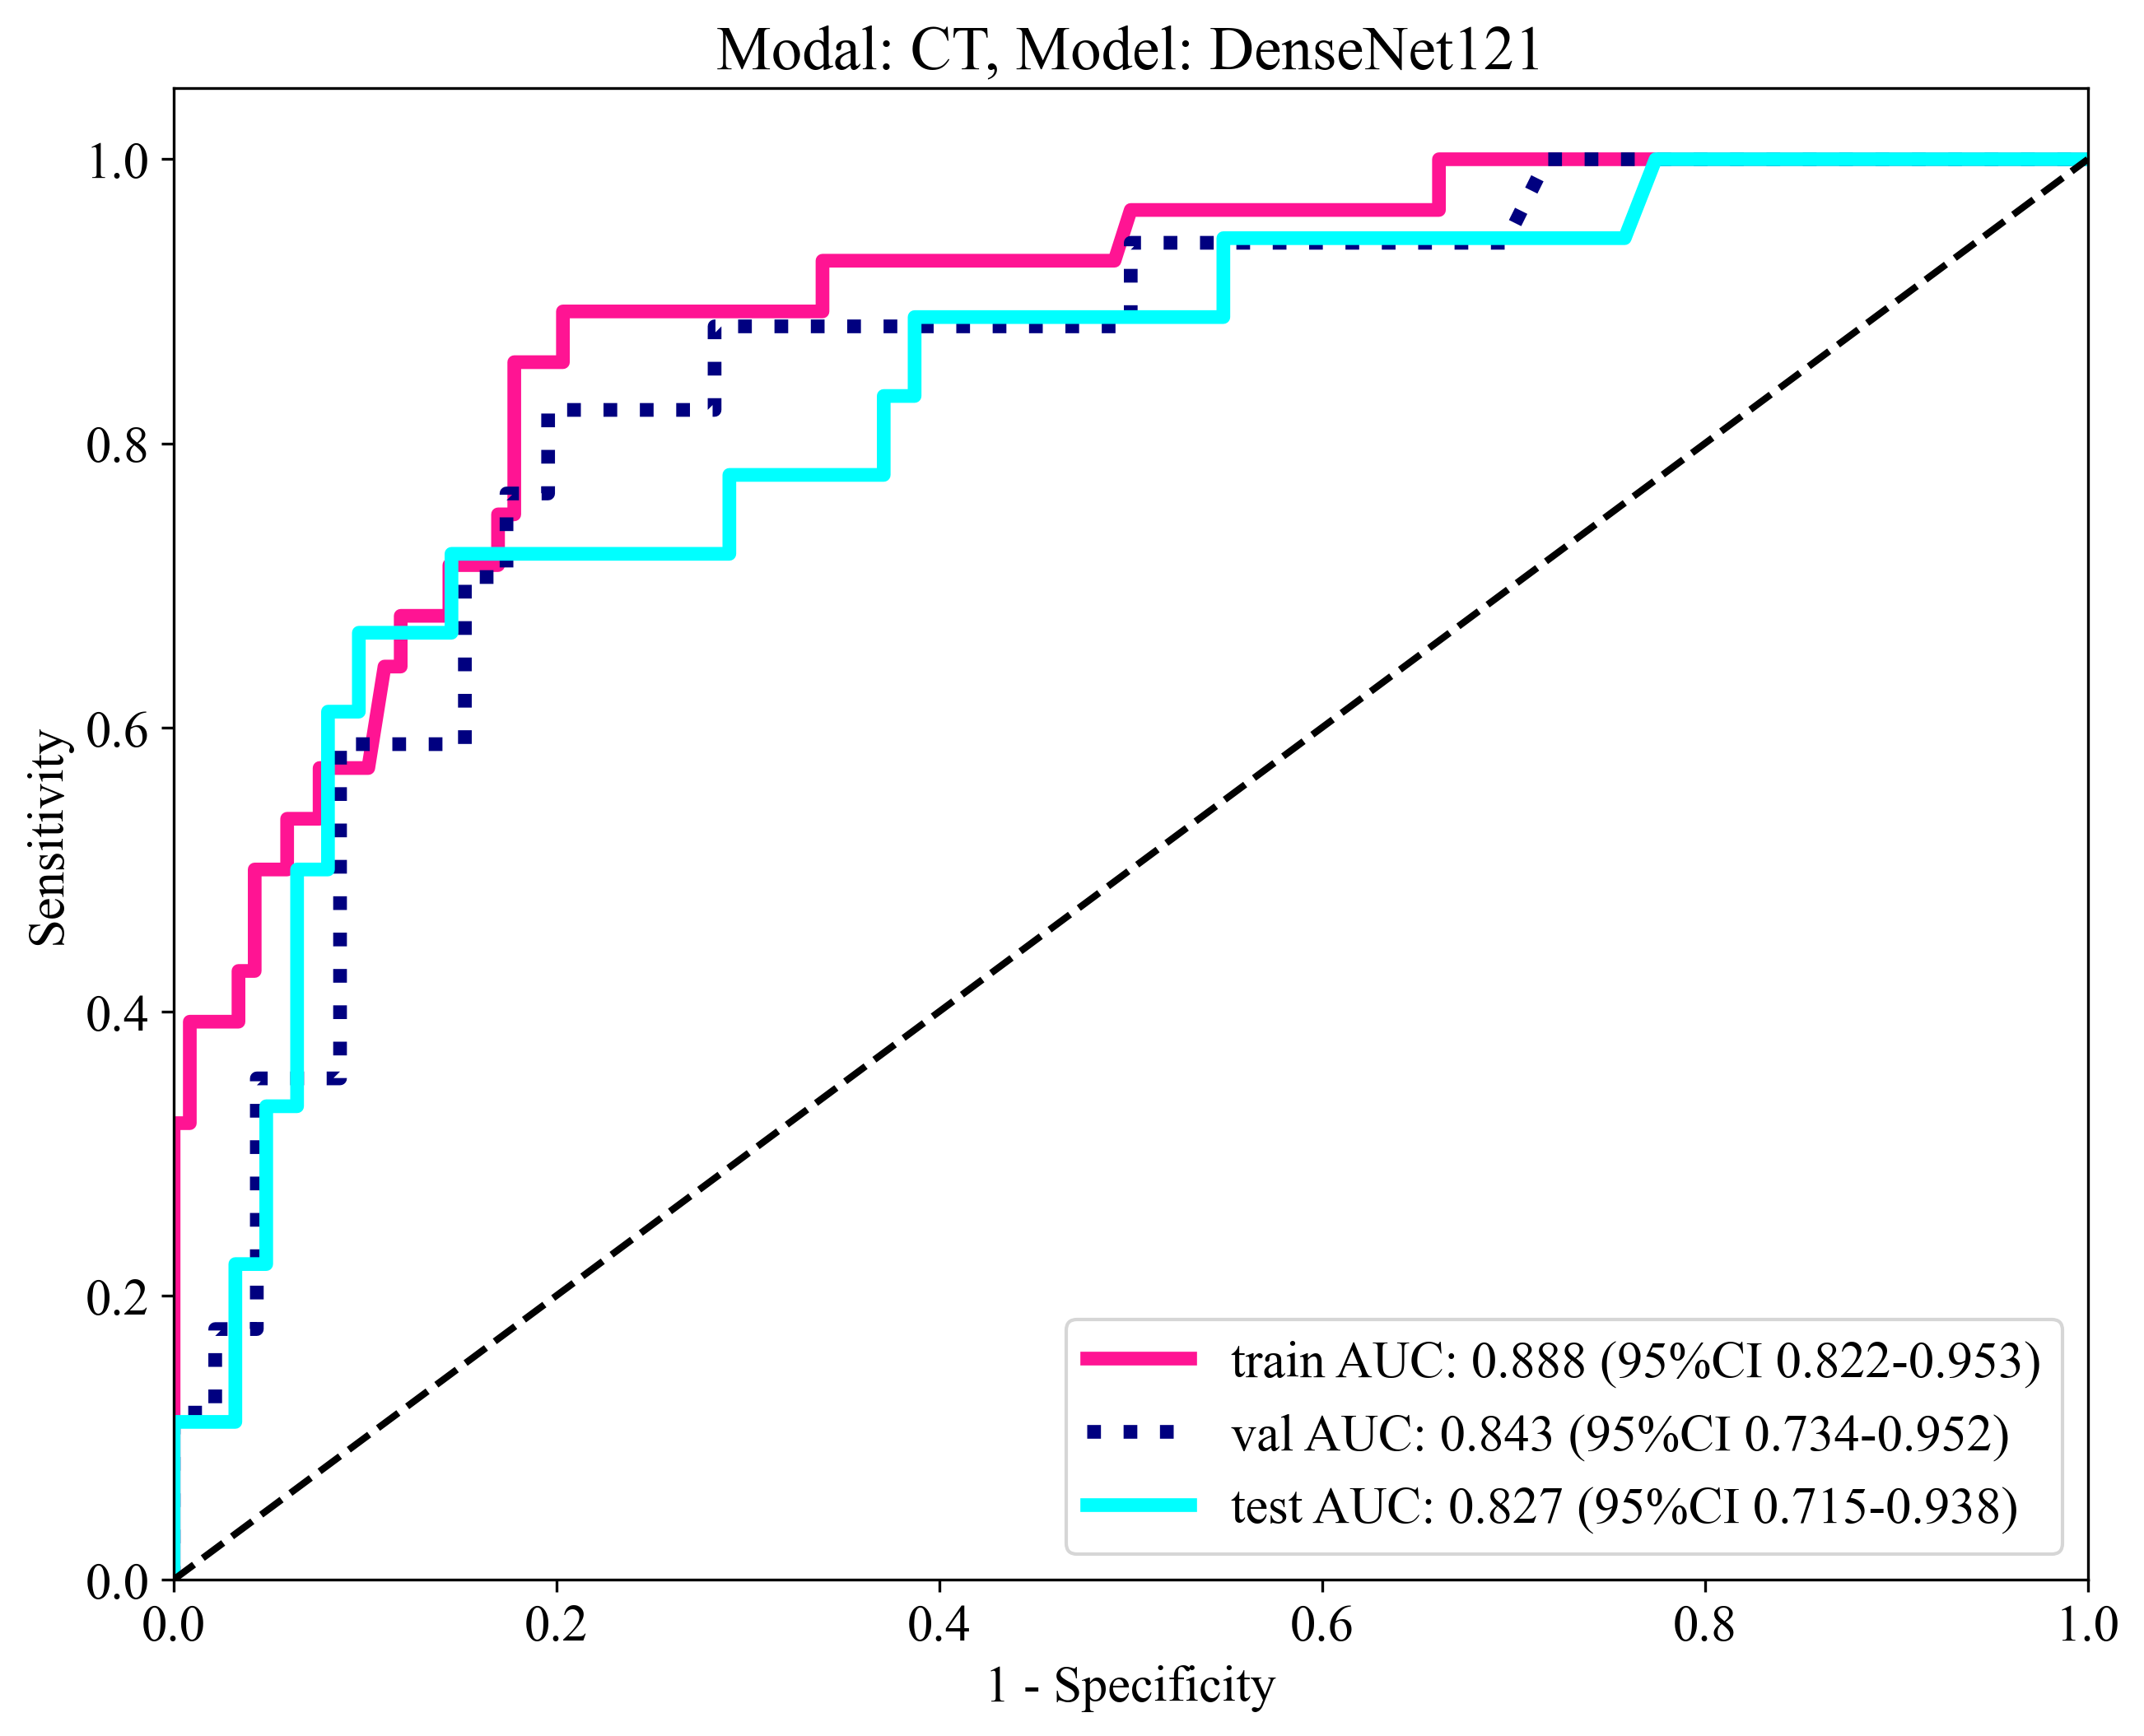

CT 29 8 train (146, 7)
CT 29 8 val (63, 7)
CT 29 8 test (80, 7)


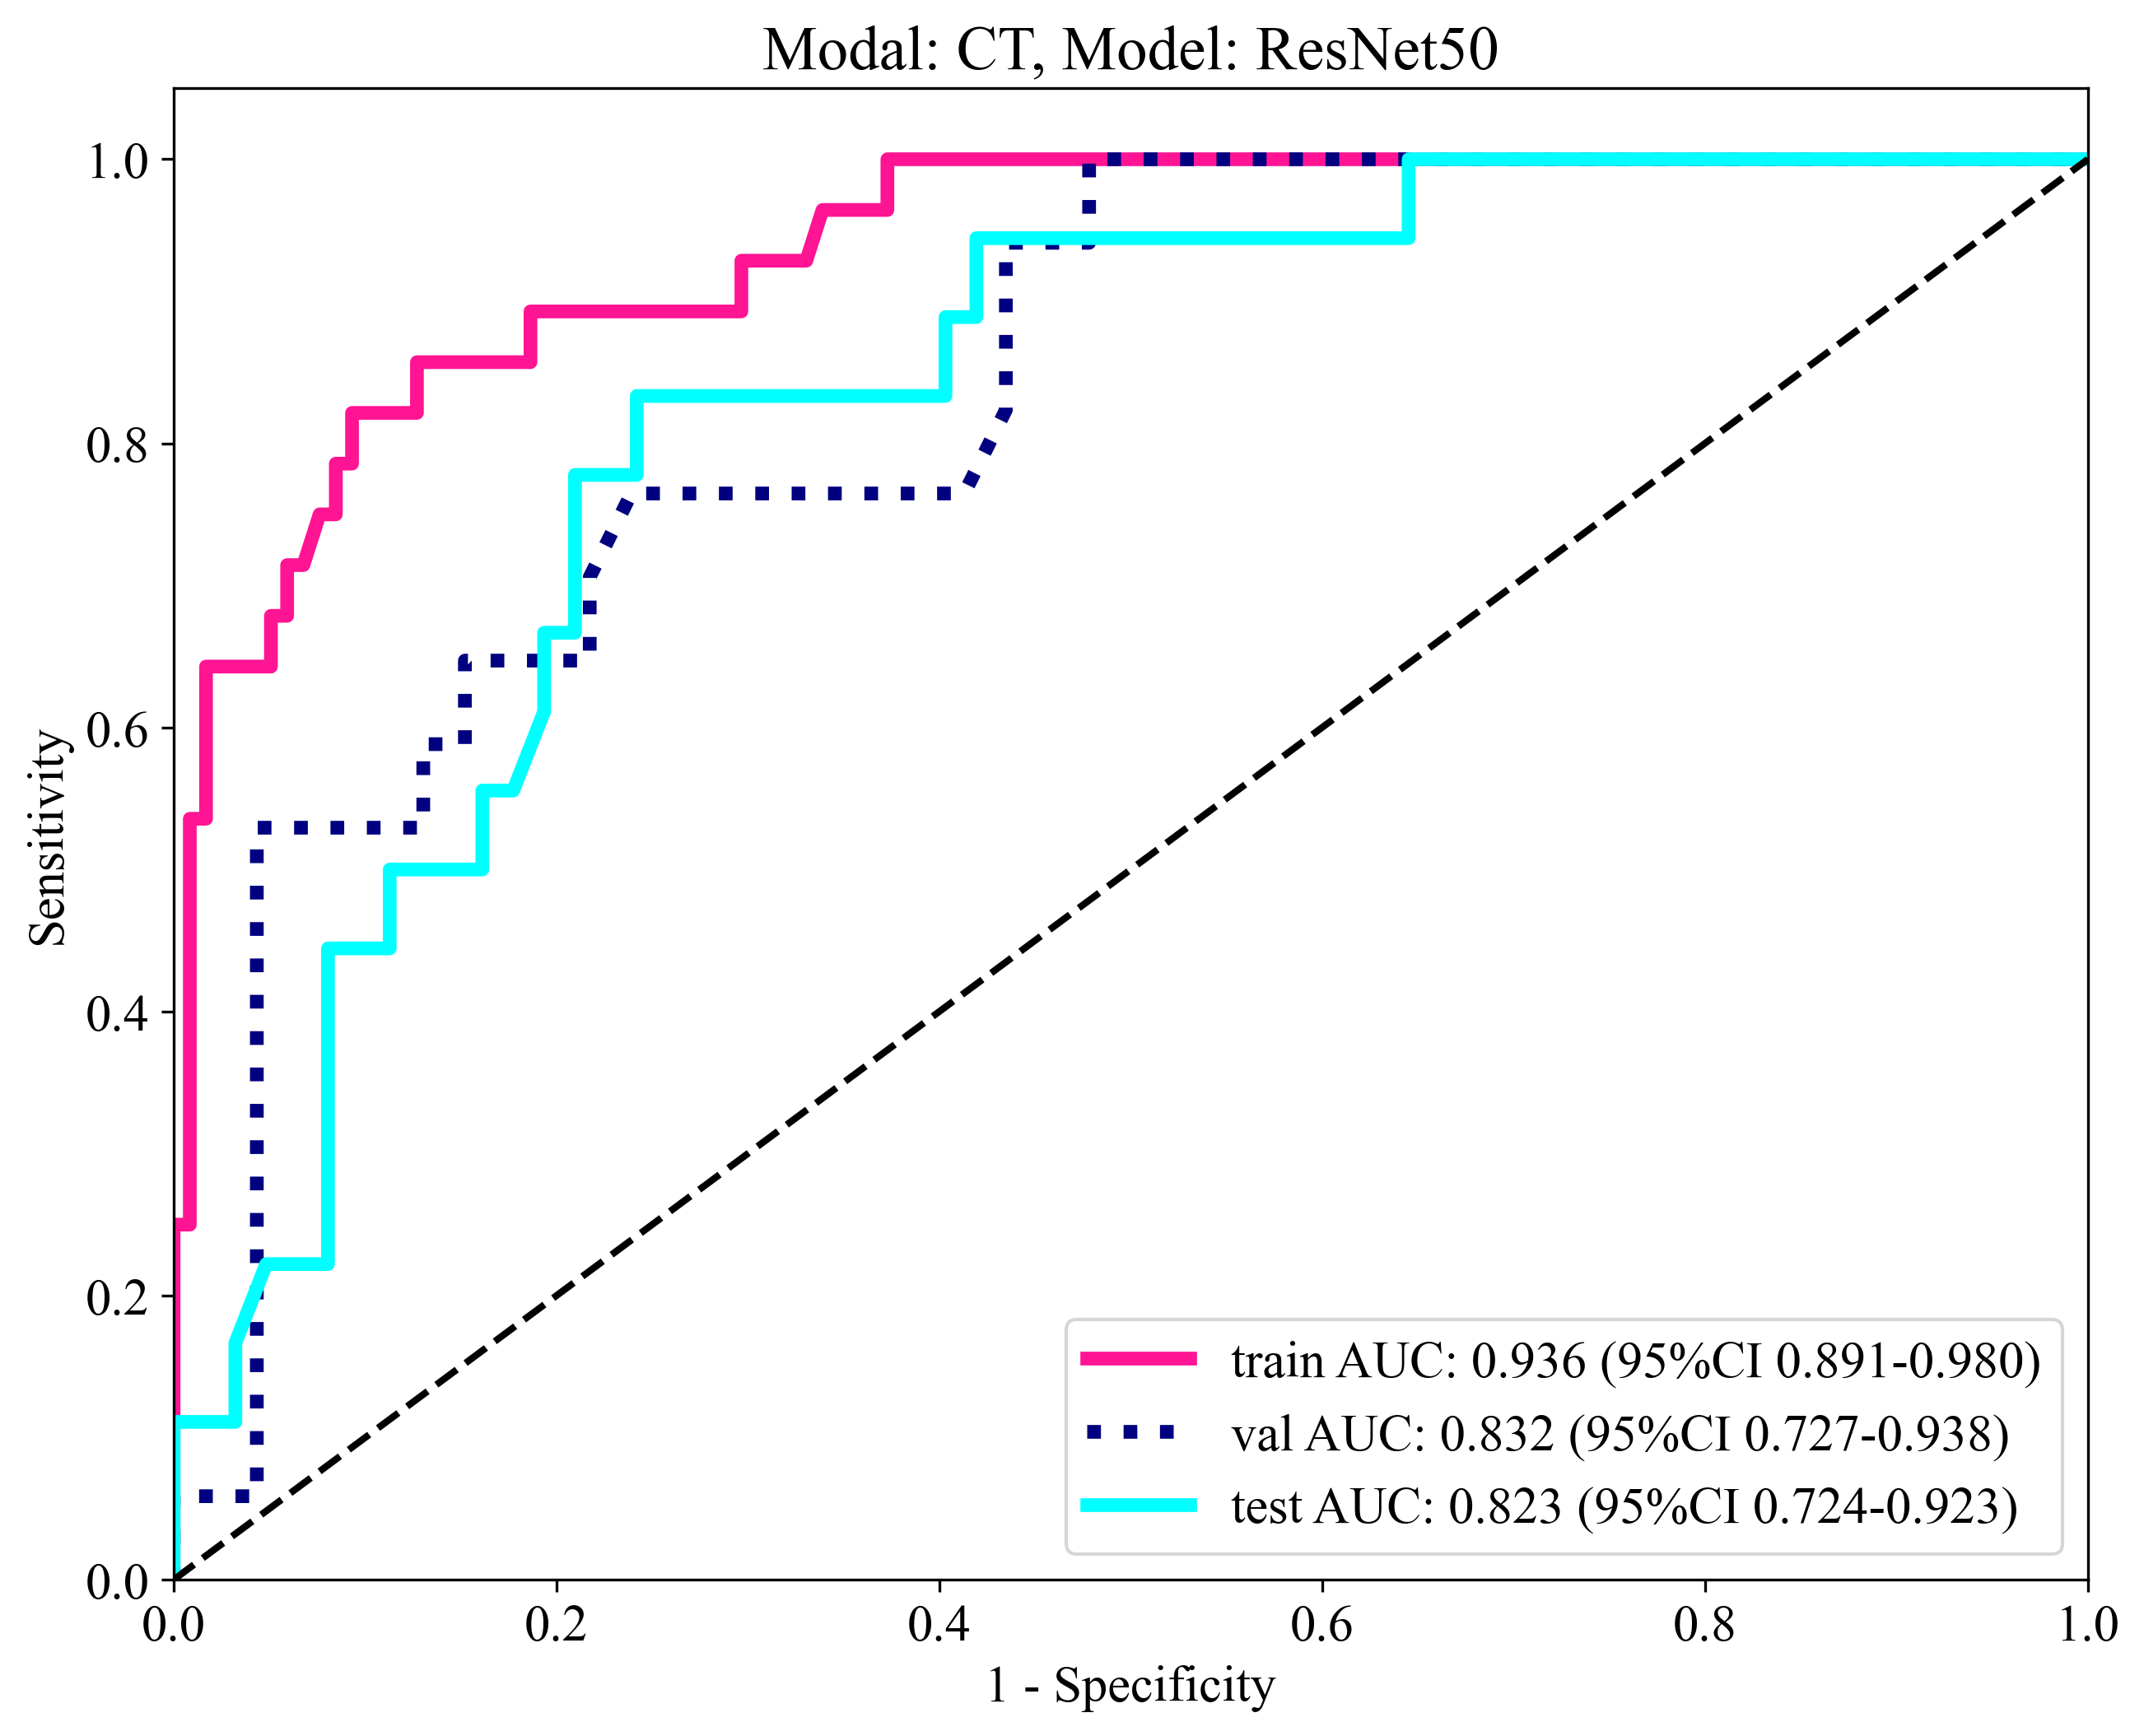

CT 29 8 train (146, 7)
CT 29 8 val (63, 7)
CT 29 8 test (80, 7)


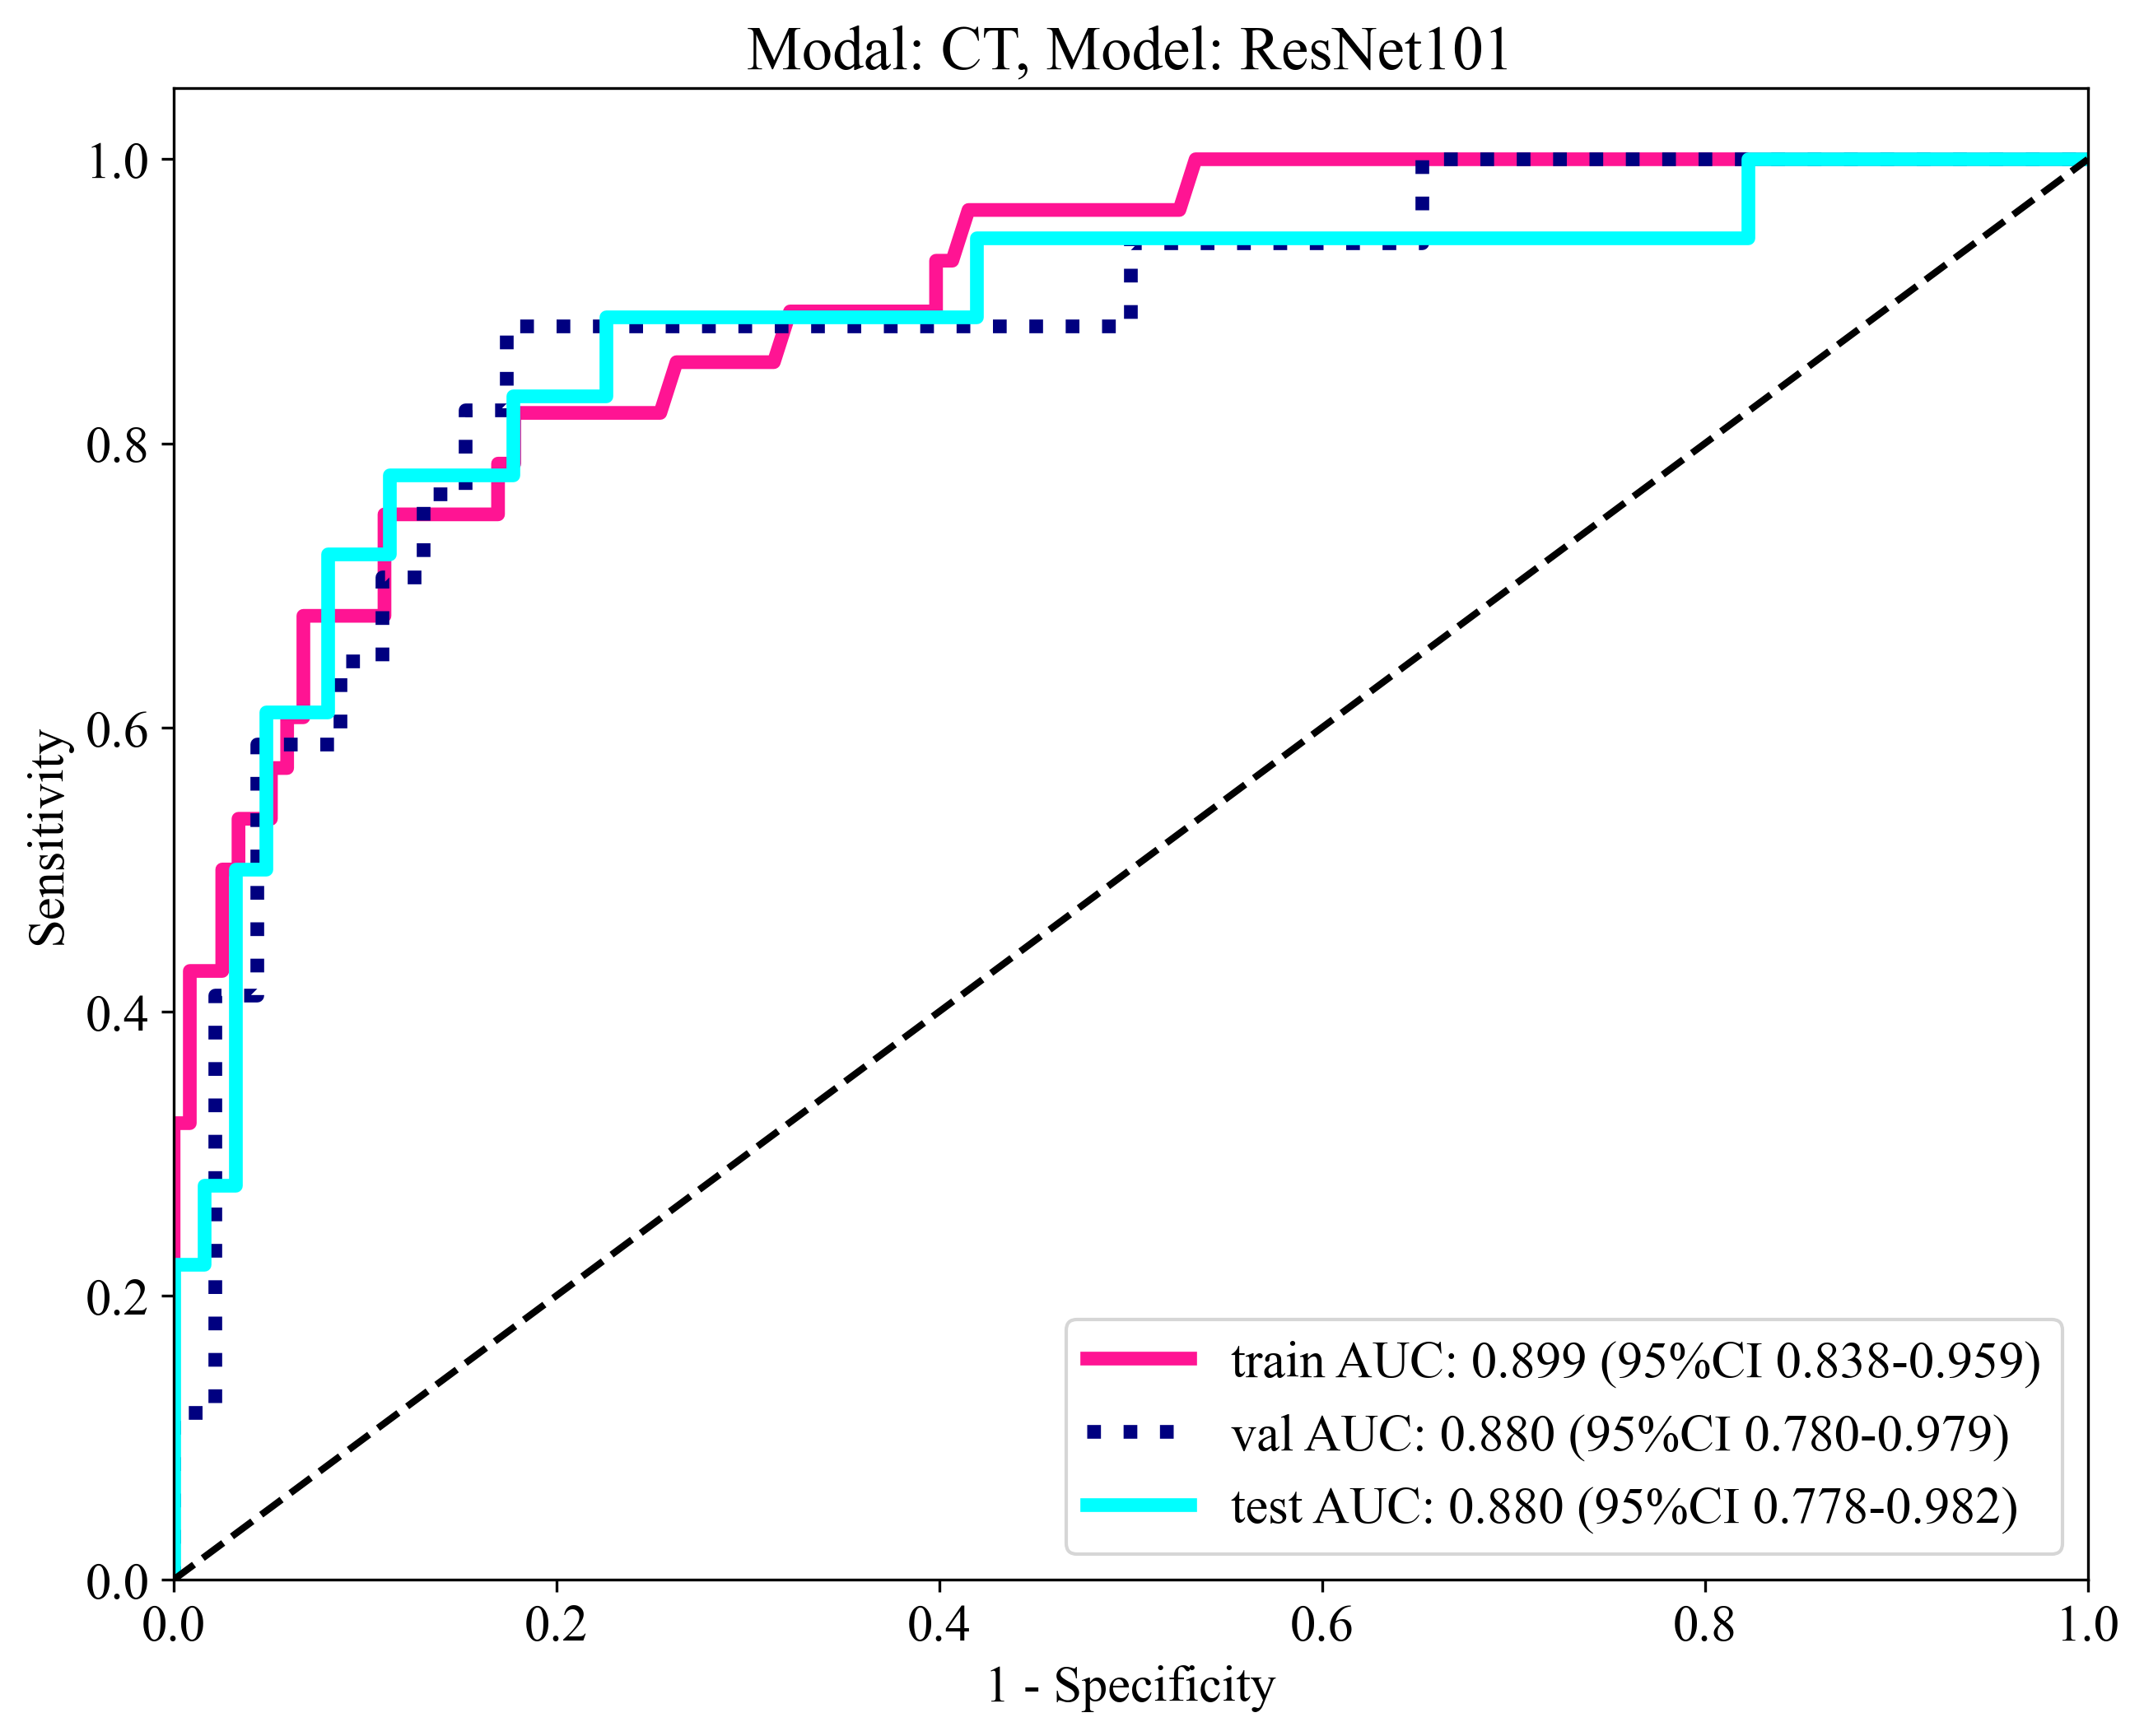

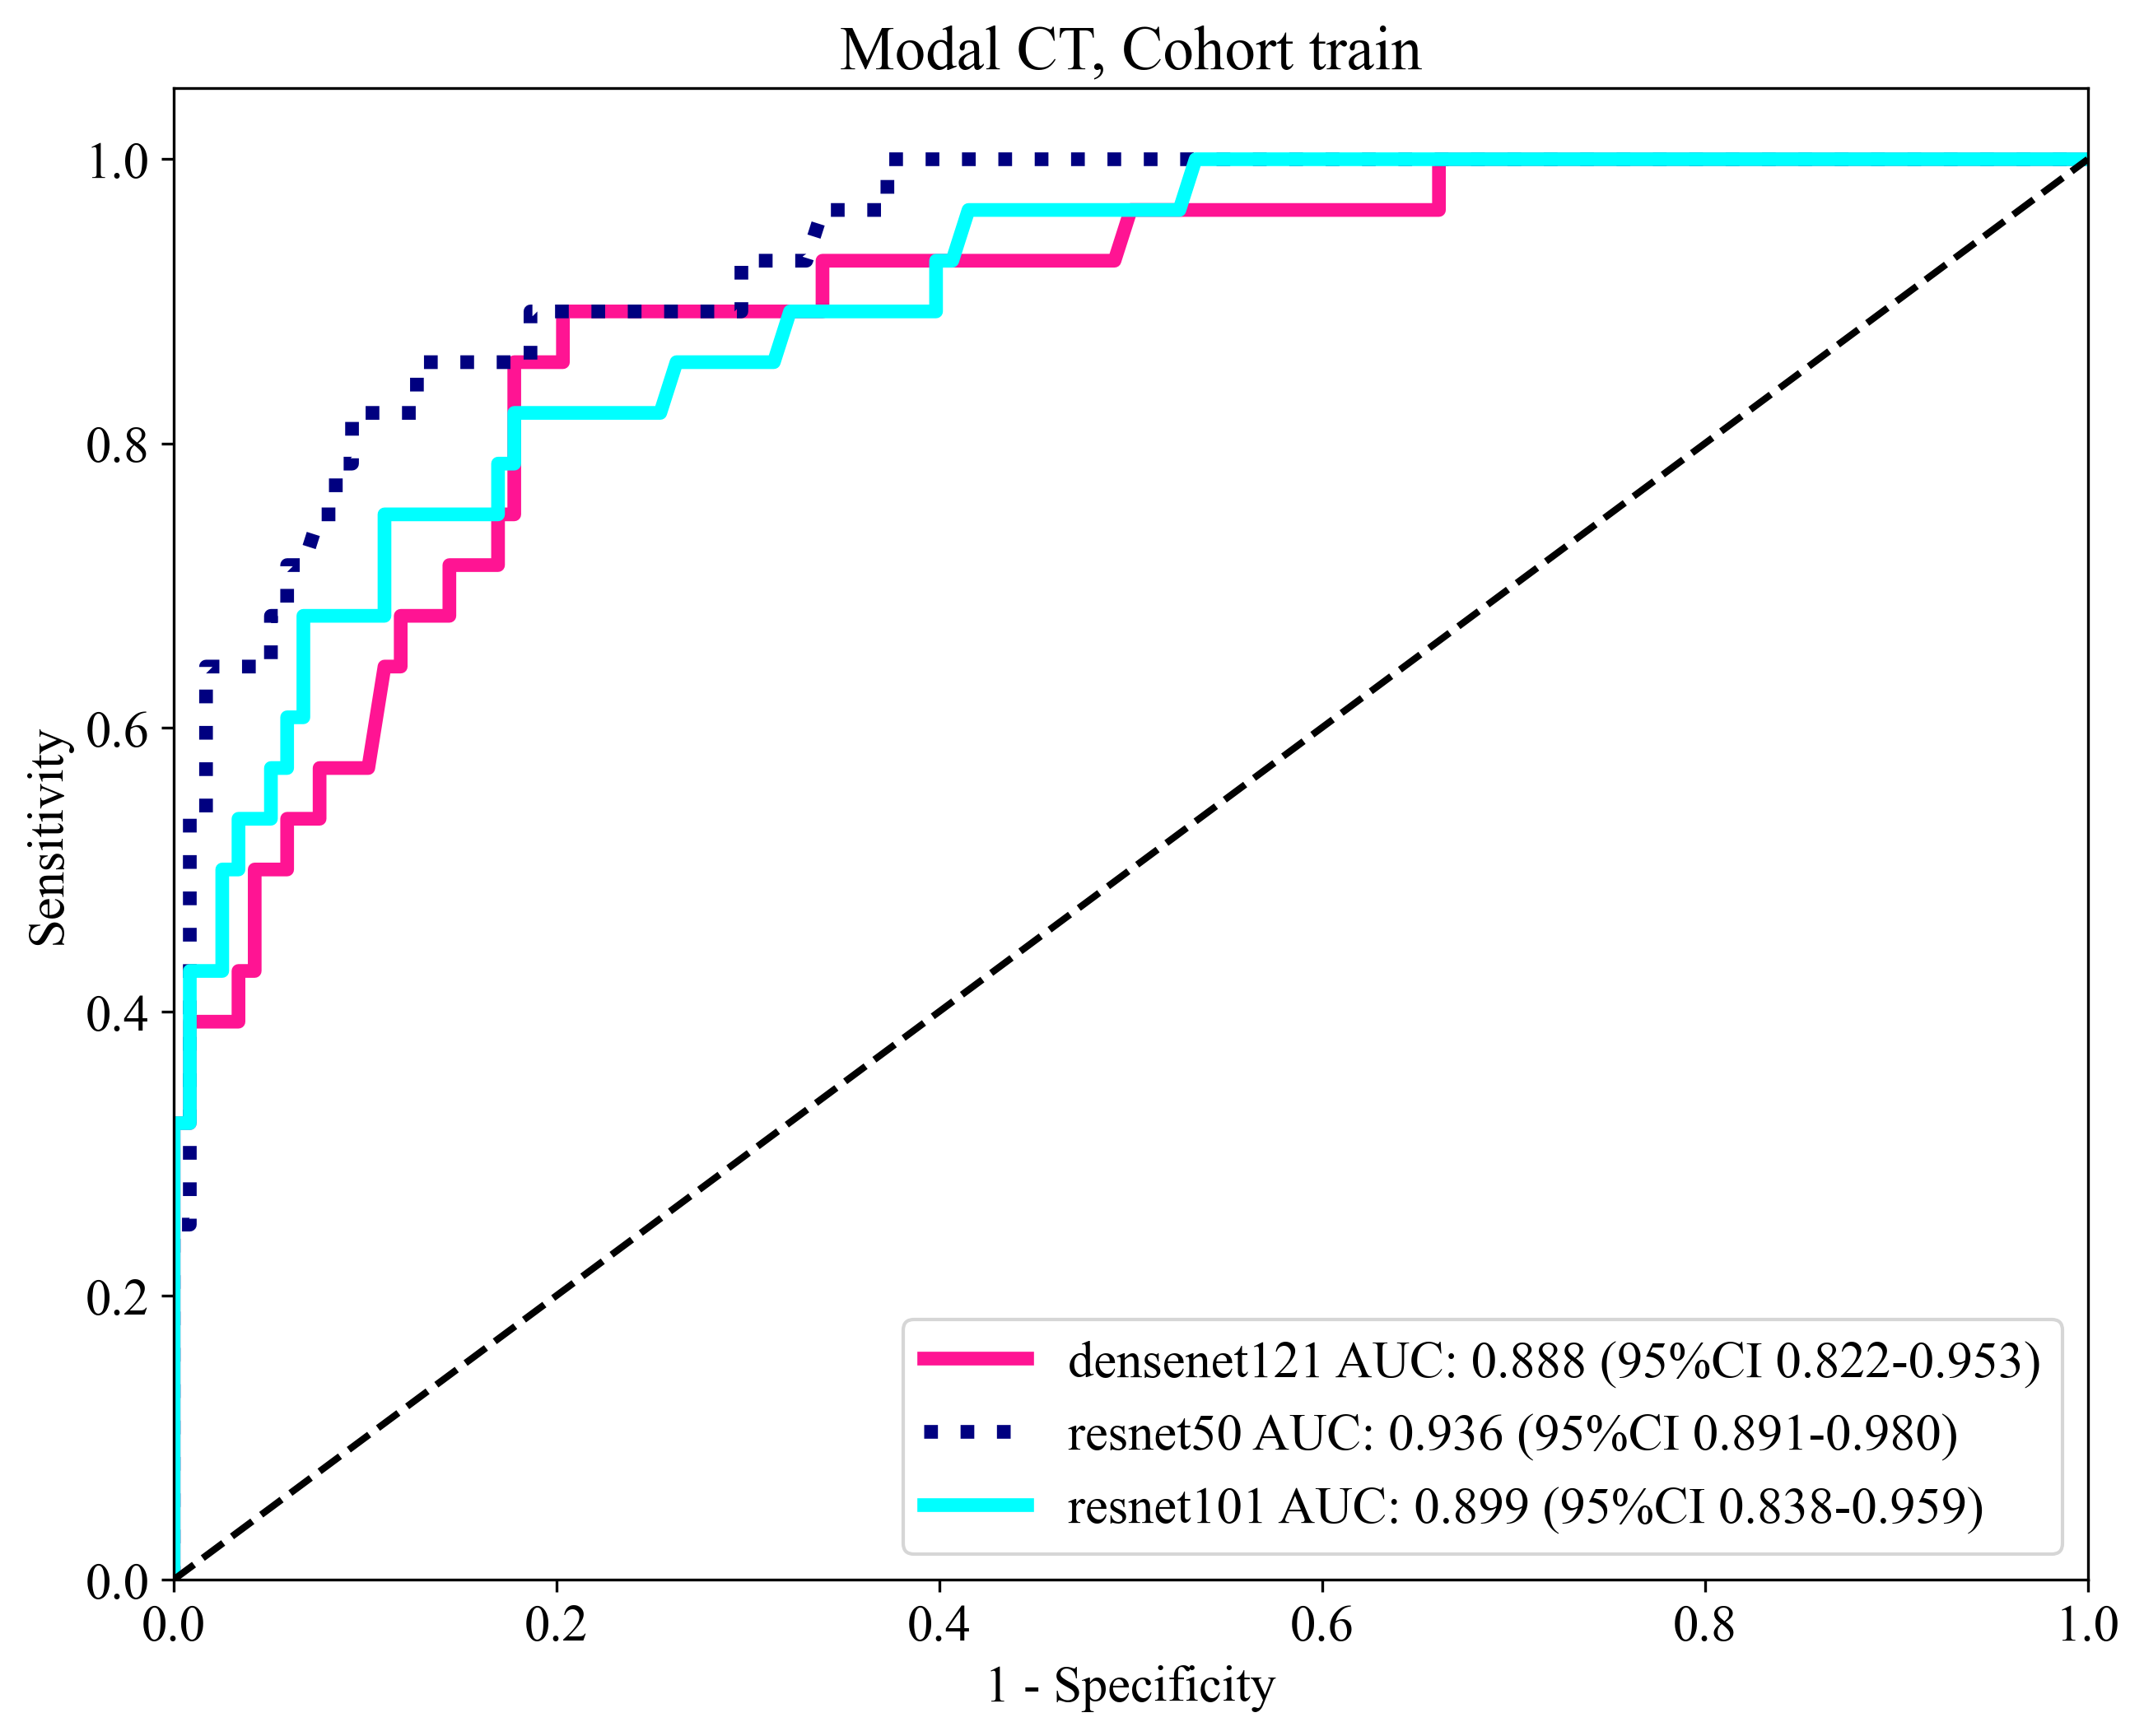

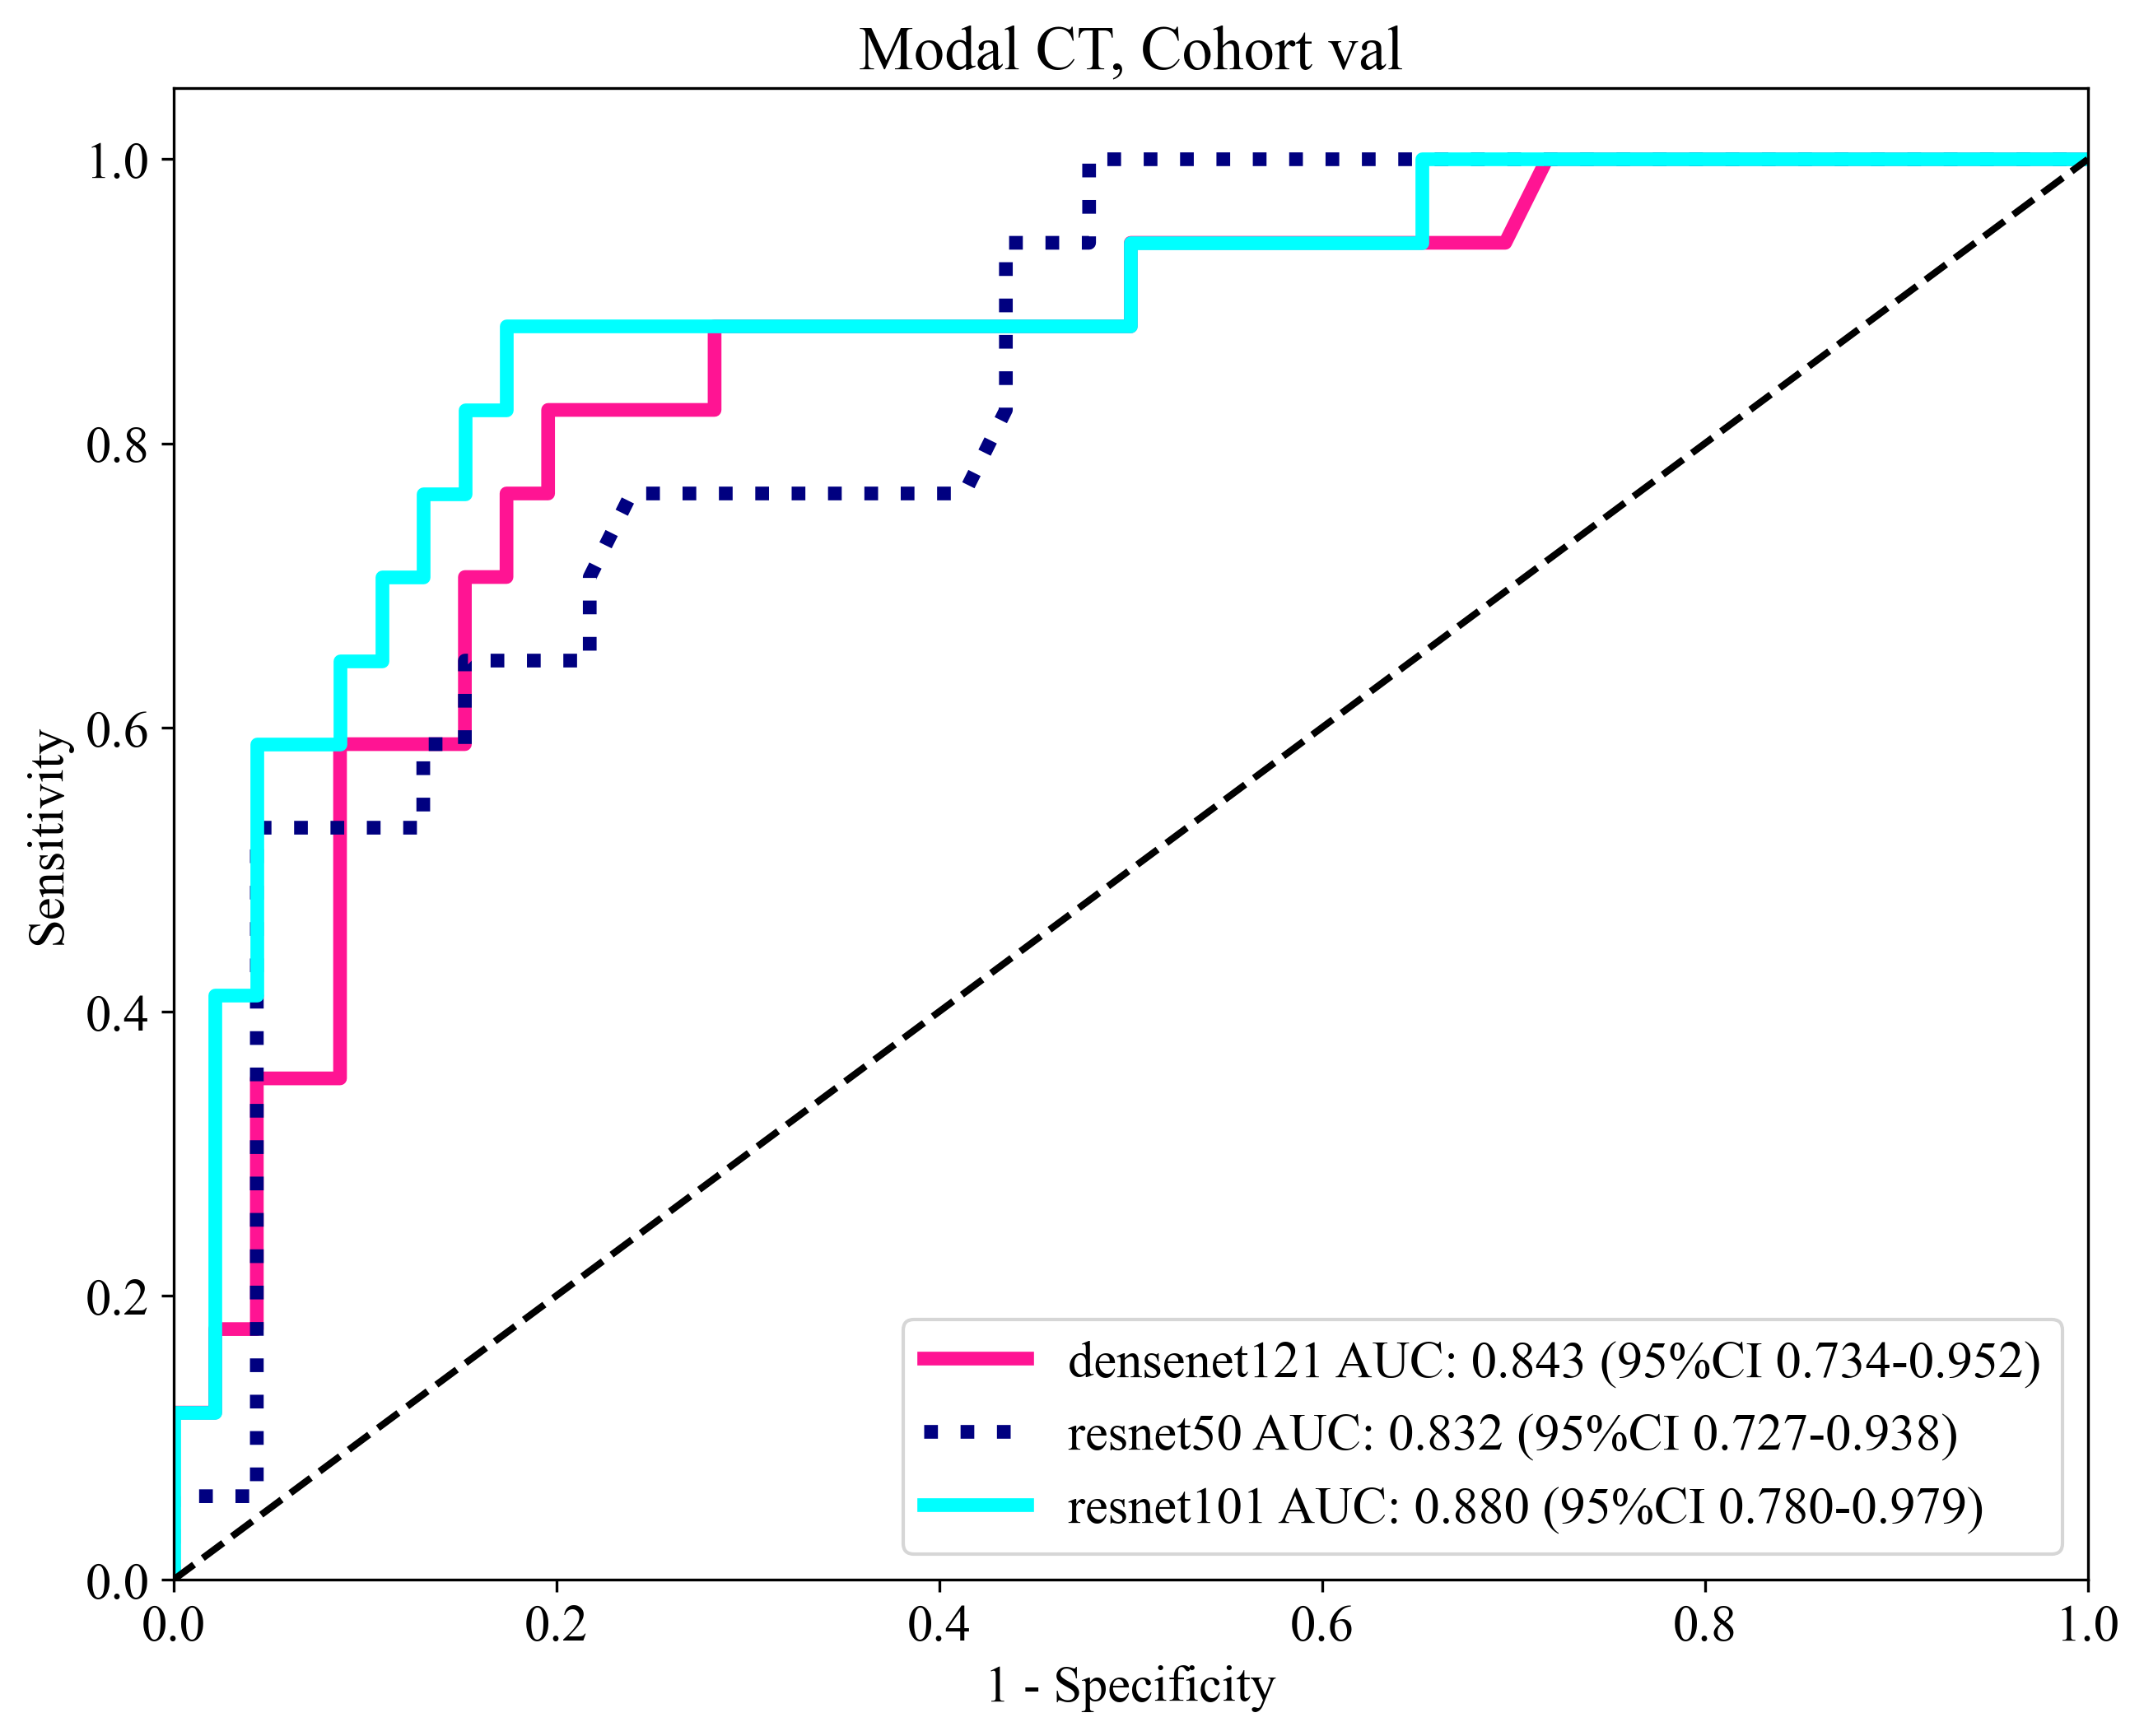

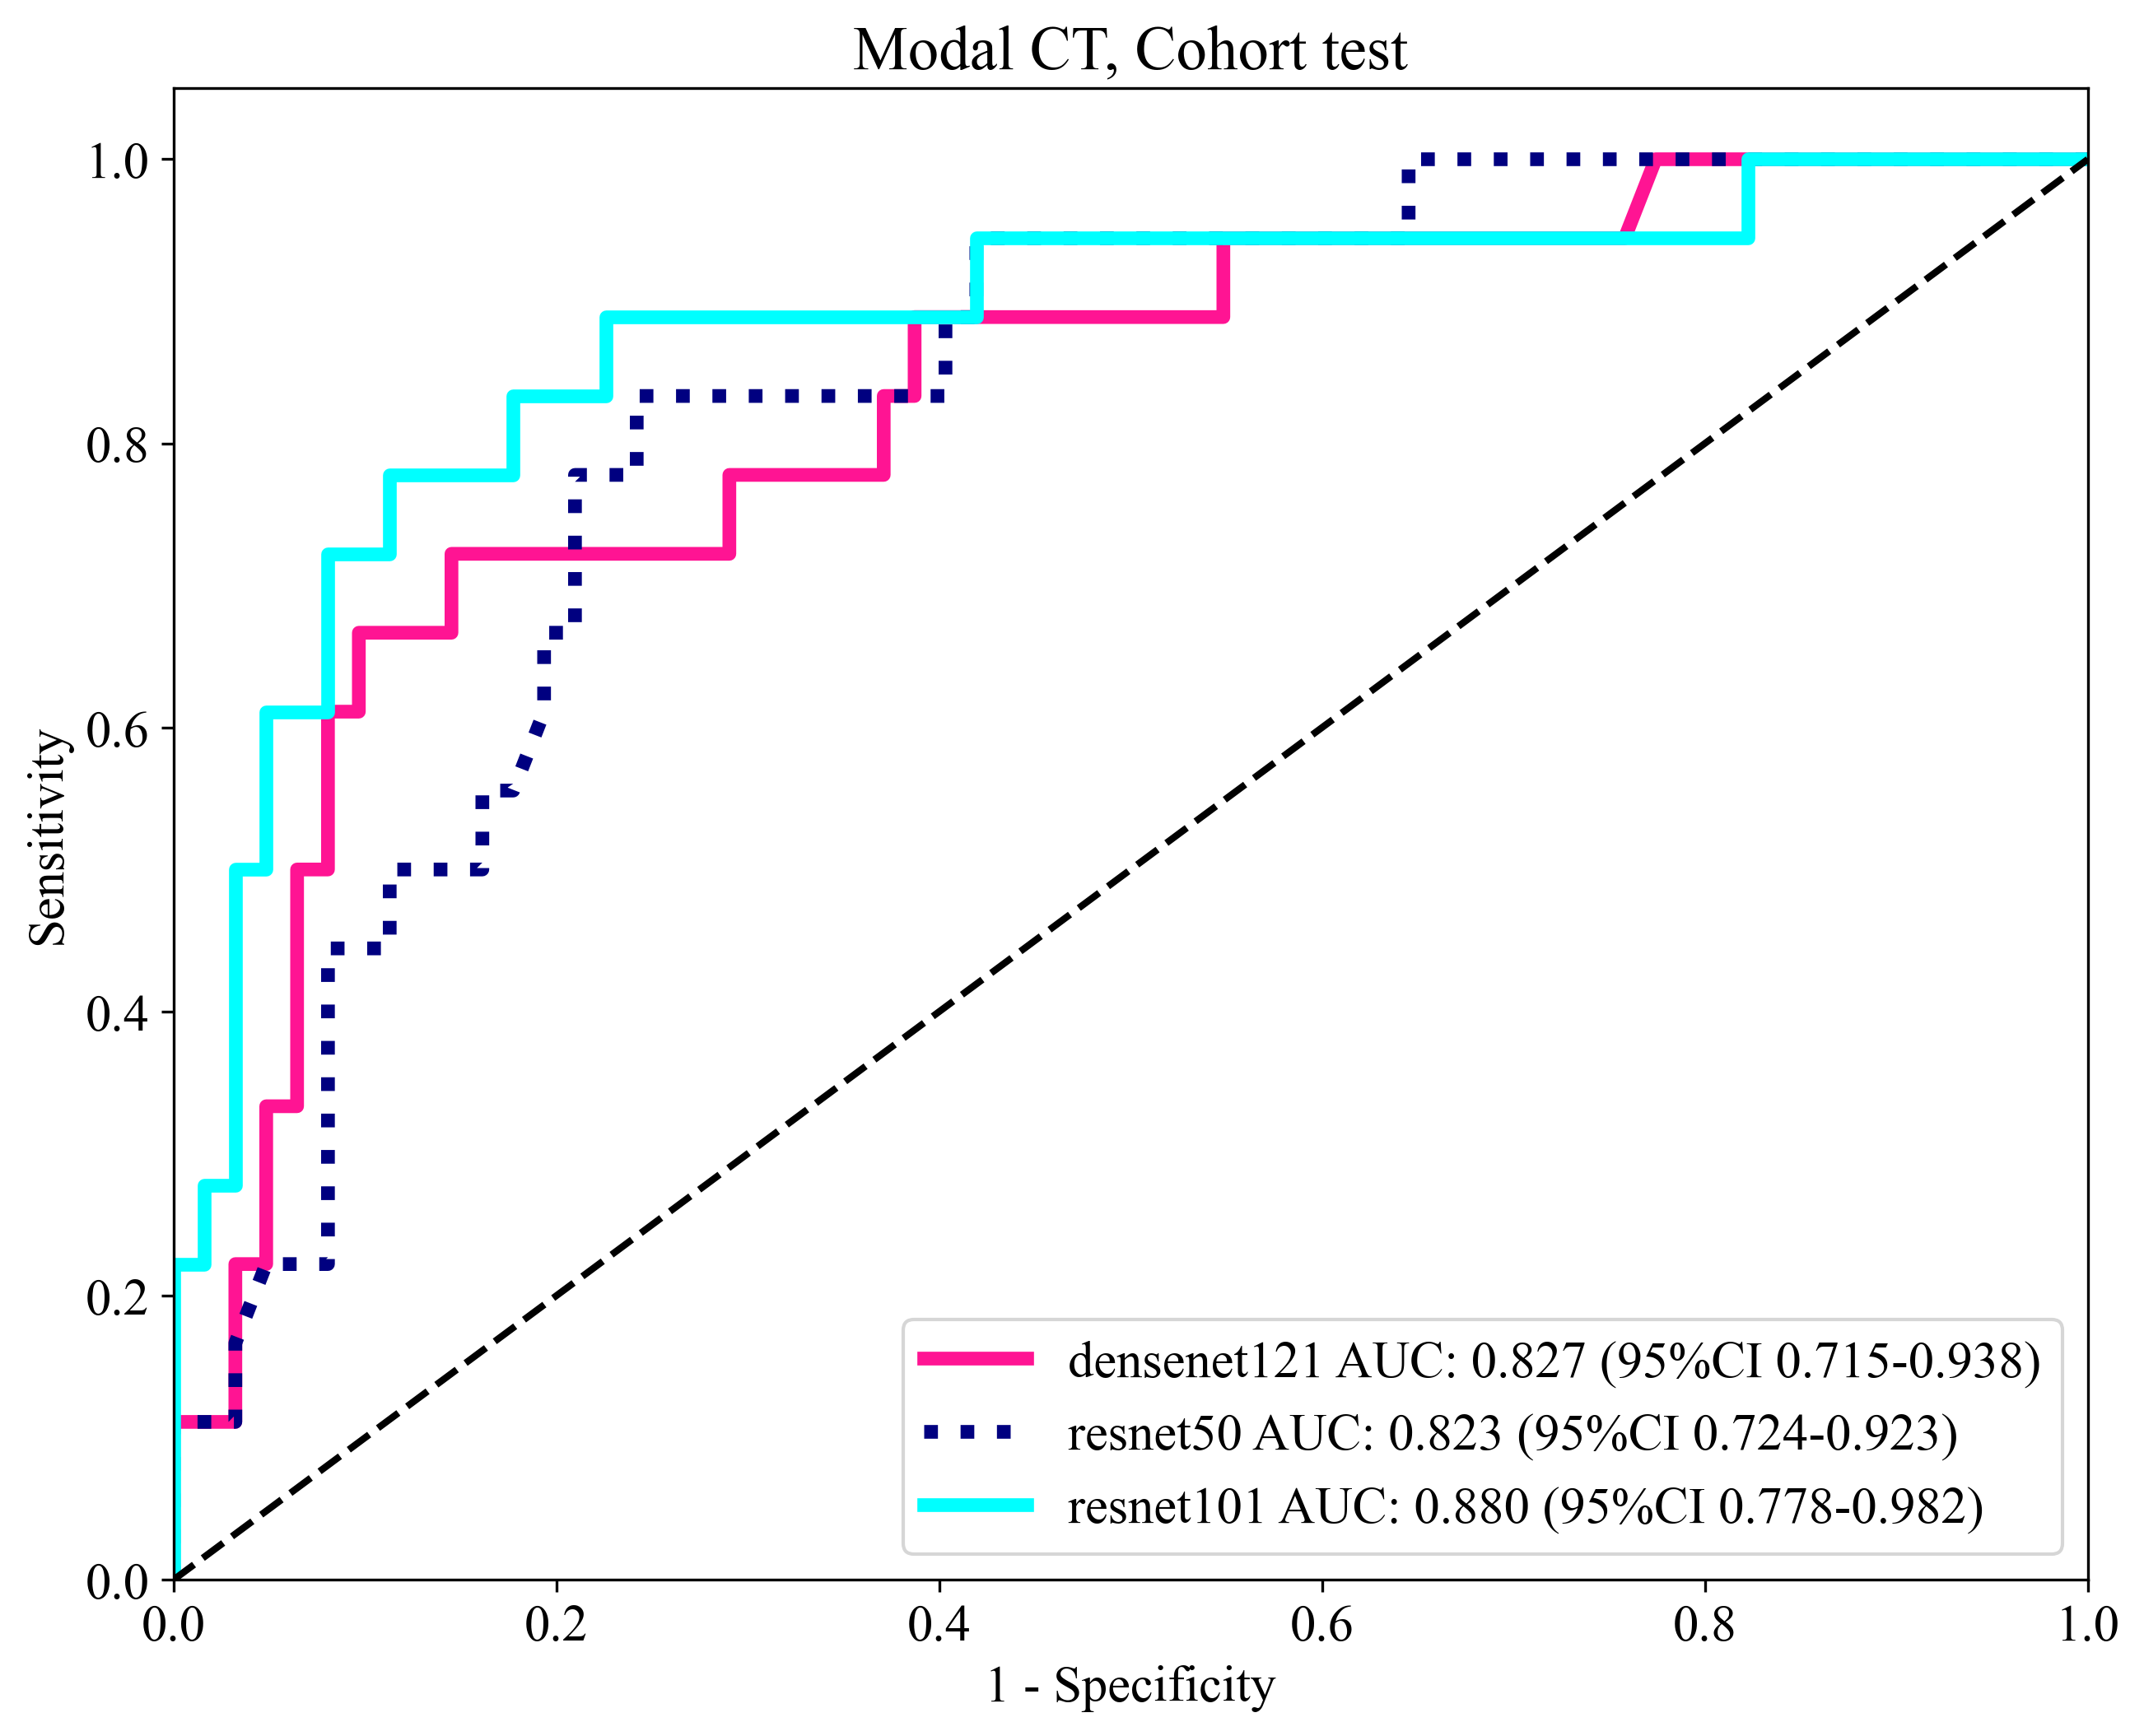

,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,densenet121,0.808,0.888,0.8217-0.9534,0.857,0.797,0.500,0.959,0.174,CT,train
1,densenet121,0.794,0.843,0.7344-0.9523,0.765,0.804,0.591,0.902,0.261,CT,val
2,densenet121,0.812,0.827,0.7149-0.9383,0.667,0.855,0.571,0.898,0.323,CT,test
3,resnet50,0.863,0.936,0.8912-0.9805,0.821,0.873,0.605,0.954,0.272,CT,train
4,resnet50,0.762,0.832,0.7269-0.9380,0.706,0.783,0.545,0.878,0.301,CT,val
5,resnet50,0.762,0.823,0.7241-0.9228,0.778,0.758,0.483,0.922,0.354,CT,test
6,resnet101,0.815,0.899,0.8378-0.9594,0.786,0.822,0.512,0.942,0.207,CT,train
7,resnet101,0.825,0.880,0.7802-0.9794,0.824,0.826,0.636,0.927,0.236,CT,val
8,resnet101,0.850,0.880,0.7780-0.9818,0.722,0.887,0.650,0.917,0.417,CT,test


,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,densenet121,0.808,0.888,0.8217-0.9534,0.857,0.797,0.500,0.959,0.174,CT,train
1,densenet121,0.794,0.843,0.7344-0.9523,0.765,0.804,0.591,0.902,0.261,CT,val
2,densenet121,0.812,0.827,0.7149-0.9383,0.667,0.855,0.571,0.898,0.323,CT,test
3,resnet50,0.863,0.936,0.8912-0.9805,0.821,0.873,0.605,0.954,0.272,CT,train
4,resnet50,0.762,0.832,0.7269-0.9380,0.706,0.783,0.545,0.878,0.301,CT,val
5,resnet50,0.762,0.823,0.7241-0.9228,0.778,0.758,0.483,0.922,0.354,CT,test
6,resnet101,0.815,0.899,0.8378-0.9594,0.786,0.822,0.512,0.942,0.207,CT,train
7,resnet101,0.825,0.880,0.7802-0.9794,0.824,0.826,0.636,0.927,0.236,CT,val
8,resnet101,0.850,0.880,0.7780-0.9818,0.722,0.887,0.650,0.917,0.417,CT,test


In [45]:
import pandas as pd
import numpy  as np
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.comp1 import draw_roc
from onekey_algo.custom.components.ugly import drop_error
from matplotlib import pyplot as plt

def get_group(x):
    x = os.path.basename(x)
    if x.startswith('train'):
        return 'train'
    elif x.startswith('val'):
        return 'val'
    else:
        return '_'.join(x.split('_')[:2])

def get_log(log_path, map2gz:bool = True):
    log_ = pd.read_csv(log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
    if map2gz:
        log_['ID'] = log_['fname'].map(lambda x: os.path.basename(x).replace('.png', '.gz'))
    else:
        log_['ID'] = log_['fname'].map(lambda x: os.path.basename(x))
    return log_

def map_mn(x):
    return x.replace('densen', 'DenseN').replace('resnet', 'ResNet').replace('vgg', 'VGG').replace('inception_v3', 'InceptionV3')

all_log = []
metrics_dfs = []
epoch_mapping = {'resnet50': {'CT': 25, 'P': 19, 'V': 18, 'dwi': 15, 't1': 19, 't2': 17, },
                 'resnet101': {'CT': 22, 'P': 19, 'V': 18, 'dwi': 15, 't1': 19, 't2': 17, },
                 'vgg19': {'CT': 22, 'P': 15, 'V': 12, 'dwi': 17, 't1': 19, 't2': 18, },
                 'densenet121': {'CT': 20, 'P': 12, 'V': 19, 'dwi': 18, 't1': 18, 't2': 15, }}
dsamples = {'val': set(), 'test': set()}
for modal in get_param_in_cwd('modals', ['CT']):
    for epoch_ in range(29, 30):
        for cv in range(8, 9):
            model_root = os.path.join(get_param_in_cwd('radio_dir'), 'vnet_models_full')
            metric_results = []
            all_preds = []
            all_gts = []
            all_model_names = []
            for model in ['densenet121', 'resnet50', 'resnet101']:
                if model != 'resnet101' and False:
                    continue
                all_pred = []
                all_gt = []
                all_groups = []
#                 val_log = pd.concat([get_log(os.path.join(model_root, model, f"viz/BST_TRAIN_RESULTS.txt")),
#                                     get_log(os.path.join(model_root, model, f"viz/BST_VAL_RESULTS.txt"))], axis=0)
#                 val_log = pd.concat([get_log(os.path.join(model_root, model, f"train/Epoch-{epoch_}.txt")),
#                                     get_log(os.path.join(model_root, model, f"valid/Epoch-{epoch_}.txt"))], axis=0)
                val_log = pd.concat([get_log(os.path.join(model_root, model, f"train/Epoch-{epoch_mapping[model][modal]}.txt")),
                                     get_log(os.path.join(model_root, model, f"valid/Epoch-{epoch_mapping[model][modal]}.txt"))], axis=0)
                val_log = pd.merge(val_log, group_info, on='ID', how='inner')
                val_log['model'] = f"{model}_{modal}"
                # display(val_log)
                ug_groups = np.unique(val_log['group'])
                ug_groups = ['train', 'val', 'test']
                ul_labels = np.unique(val_log['pred_label'])
                for g in ug_groups:
                    sub_group = val_log[val_log['group'] == g]
                    if g in ['val'] and False:
                        if modal in ['CT']:
                            if len(dsamples[g]) < (1 if g == 'val' else 8):
                                sel_idx, = drop_error([sub_group['pred_label']], [sub_group['gt']], [sub_group['pred_score']], 
                                                      ratio=1 if g == 'val' else 4, verbose=True)
                                print(g, sub_group.shape, sub_group[sel_idx].shape, 
                                      set(sub_group['fname'])-set(sub_group[sel_idx]['fname']))
                                drop_s = set(sub_group['fname'])-set(sub_group[sel_idx]['fname'])
                                dsamples[g] |= set([os.path.basename(s).replace('.png', '.gz') for s in drop_s])
                        sub_group = sub_group[~sub_group['ID'].isin(dsamples[g])]
                    print(modal, epoch_, cv, g, sub_group.shape)
                    all_log.append(sub_group)
                    sub_group['label-1'] = list(map(lambda x: x[0] if x[1] == 1 else 1-x[0], 
                                                    np.array(sub_group[['pred_score', 'pred_label']])))
                    sub_group['label-0'] = 1 - sub_group['label-1']
                    sub_group[['ID', 'label-0', 'label-1']].to_csv(os.path.join('results', f'{modal}_2DL_{model}_{g}.csv'), index=False)
                    all_groups.append(g)
                    for ul in [1]:
                        pred_score = np.array(sub_group['label-1'])
                        gt = [1 if gt_ == ul else 0 for gt_ in np.array(sub_group['gt'])]
                        acc, auc, ci, tpr, tnr, ppv, npv, _, _, _, thres = metrics.analysis_pred_binary(gt, pred_score, use_youden=True)
                        ci = f"{ci[0]:.4f}-{ci[1]:.4f}"
                        metric_results.append([model, acc, auc, ci, tpr, tnr, ppv, npv, thres, modal, g])
                        all_pred.append(pred_score)
                        all_gt.append(gt)
                # 绘制每个模型的ROC
                draw_roc(all_gt, all_pred, labels=all_groups, title=f"Modal: {modal}, Model: {map_mn(model)}")
                plt.savefig(f'img/{modal}_2DTL_{model}_roc.svg', bbox_inches='tight')
                plt.show()
                # 整合到所有模型汇总。
                all_preds.extend(all_pred)
                all_gts.extend(all_gt)
                all_model_names.append(model)
            for gi, g in enumerate(all_groups):
                draw_roc(all_gts[gi::len(all_groups)], all_preds[gi::len(all_groups)], labels=all_model_names, 
                         title=f"Modal {modal}, Cohort {g}")
                plt.savefig(f'img/{modal}_2DTL_{g}_roc.svg', bbox_inches='tight')
                plt.show()
            metrics_df = pd.DataFrame(metric_results, 
                         columns=['ModelName', 'Acc', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
                                  'Youden', 'Modal', 'Cohort'])
            display(metrics_df)
            metrics_dfs.append(metrics_df)
            
all_log = pd.concat(all_log, axis=0)
all_log['ID'] = all_log['fname'].map(lambda x: os.path.basename(x))
pd.concat(metrics_dfs, axis=0)

In [3]:
import pandas as pd
from onekey_algo import get_param_in_cwd

ds = []
for subset in ['train', 'val', 'test']:
    d = pd.read_csv(f'results/DL_resnet101_{subset}.csv')
    ds.append(d)
    print(subset, d.shape)
data = pd.concat(ds, axis=0)
data['ID'] = data['ID'].map(lambda x: x.replace('.nii.png', '.nii.gz'))
group_info = pd.merge(pd.read_csv(get_param_in_cwd('label_file')), data['ID'], on='ID', how='inner')
group_info.to_csv('group.csv', index=False)
group_info

train (223, 3)
val (96, 3)
test (98, 3)


,ID,label,group
0,468.nii.gz,1,train
1,2222.nii.gz,0,train
2,336.nii.gz,0,train
3,660.nii.gz,0,train
4,2279.nii.gz,0,train
...,...,...,...
412,2147.nii.gz,0,test
413,2165.nii.gz,0,test
414,2198.nii.gz,0,test
415,2210.nii.gz,1,test


In [4]:
group_info.drop_duplicates('ID')['group'].value_counts()

train    223
test      98
val       96
Name: group, dtype: int64

In [5]:
data

,ID,label-0,label-1
0,1698.nii.gz,0.935,0.065
1,380.nii.gz,0.389,0.611
2,2242.nii.gz,0.572,0.428
3,1450.nii.gz,0.807,0.193
4,79.nii.gz,0.778,0.222
...,...,...,...
93,3059.nii.gz,0.607,0.393
94,3052(1).nii.gz,0.081,0.919
95,3018.nii.gz,0.576,0.424
96,3046.nii.gz,0.891,0.109
